In [1]:
import os
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

2024-09-05 16:58:36.269829: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 16:58:36.269854: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 16:58:36.270682: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-05 16:58:36.275674: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-05 16:58:36.908282: W tensorflow/compiler/tf2

In [2]:
algorithm = 'BunDLeNet'
rat_name = 'gatsby'

file_pattern = f'../../data/generated/saved_Y/{{}}__{algorithm}_rat_{rat_name}'
y0_tr = np.loadtxt(file_pattern.format('y0_tr'))
y1_tr = np.loadtxt(file_pattern.format('y1_tr'))
y0_tst = np.loadtxt(file_pattern.format('y0_tst'))
y1_tst = np.loadtxt(file_pattern.format('y1_tst'))
b_train_1 = np.loadtxt(file_pattern.format('b_train_1'))
b_test_1 = np.loadtxt(file_pattern.format('b_test_1'))

y0_tr = y0_tr.reshape(y0_tr.shape[0],-1)
y1_tr = y1_tr.reshape(y1_tr.shape[0],-1)
y0_tst = y0_tst.reshape(y0_tst.shape[0],-1)
y1_tst = y1_tst.reshape(y1_tst.shape[0],-1)
ydiff_tr = y1_tr - y0_tr
ydiff_tst = y1_tst - y0_tst

<IPython.core.display.Javascript object>


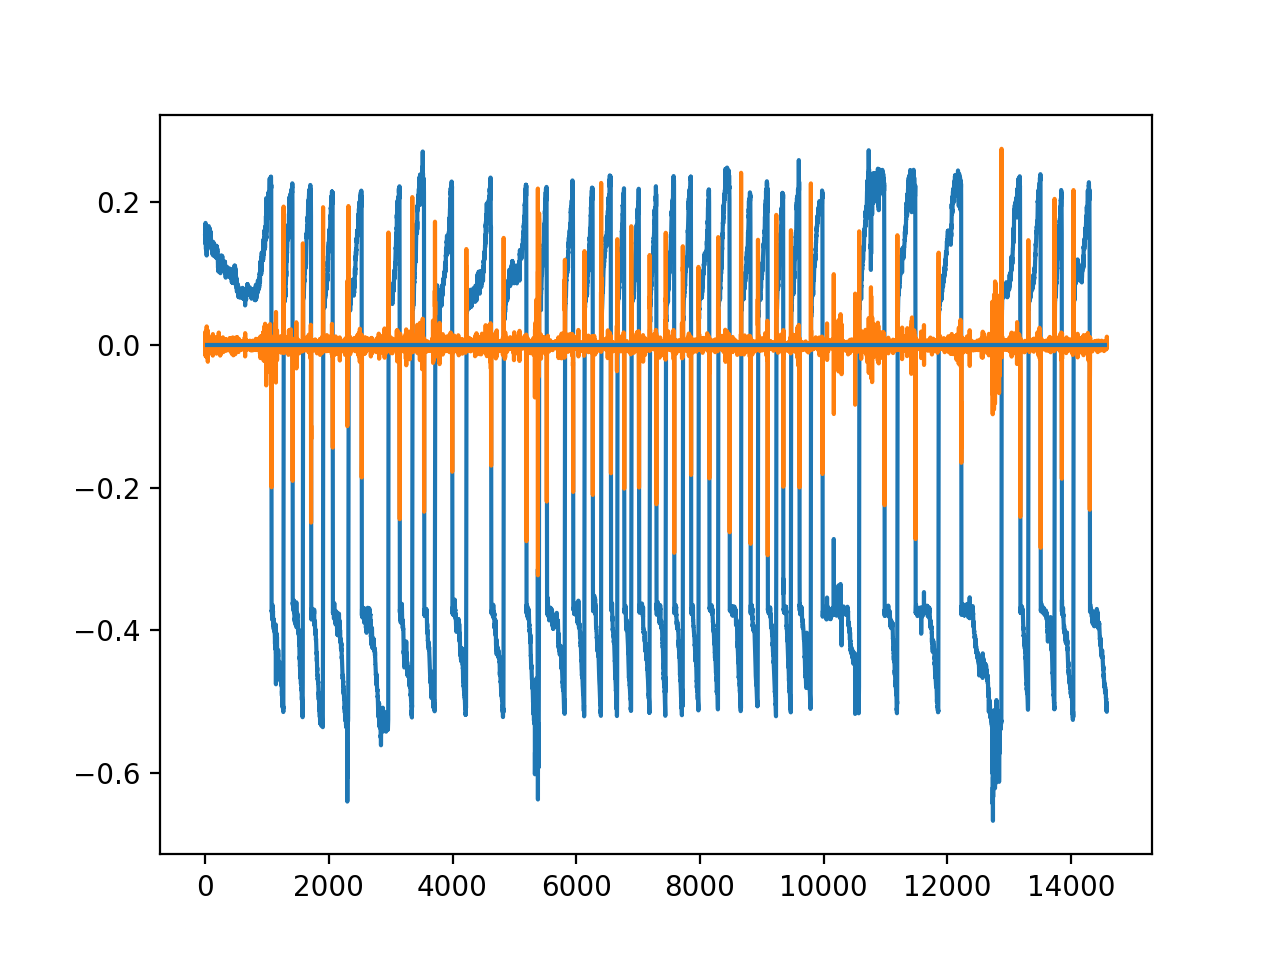

In [3]:
%matplotlib notebook
window_size = 1
moving_average = np.convolve(ydiff_tr[:,0], np.ones(window_size)/window_size, mode='valid')
plt.figure()
# plt.plot(ydiff_tr[:,0])
plt.plot(y0_tr[:,0])
plt.plot(np.arange(window_size,moving_average.shape[0]+window_size), moving_average)
plt.hlines(y=0, xmin=0, xmax=moving_average.shape[0])
plt.show()

In [4]:
# y0_tr[window_size-1:,1].shape, moving_average[:].shape

<IPython.core.display.Javascript object>


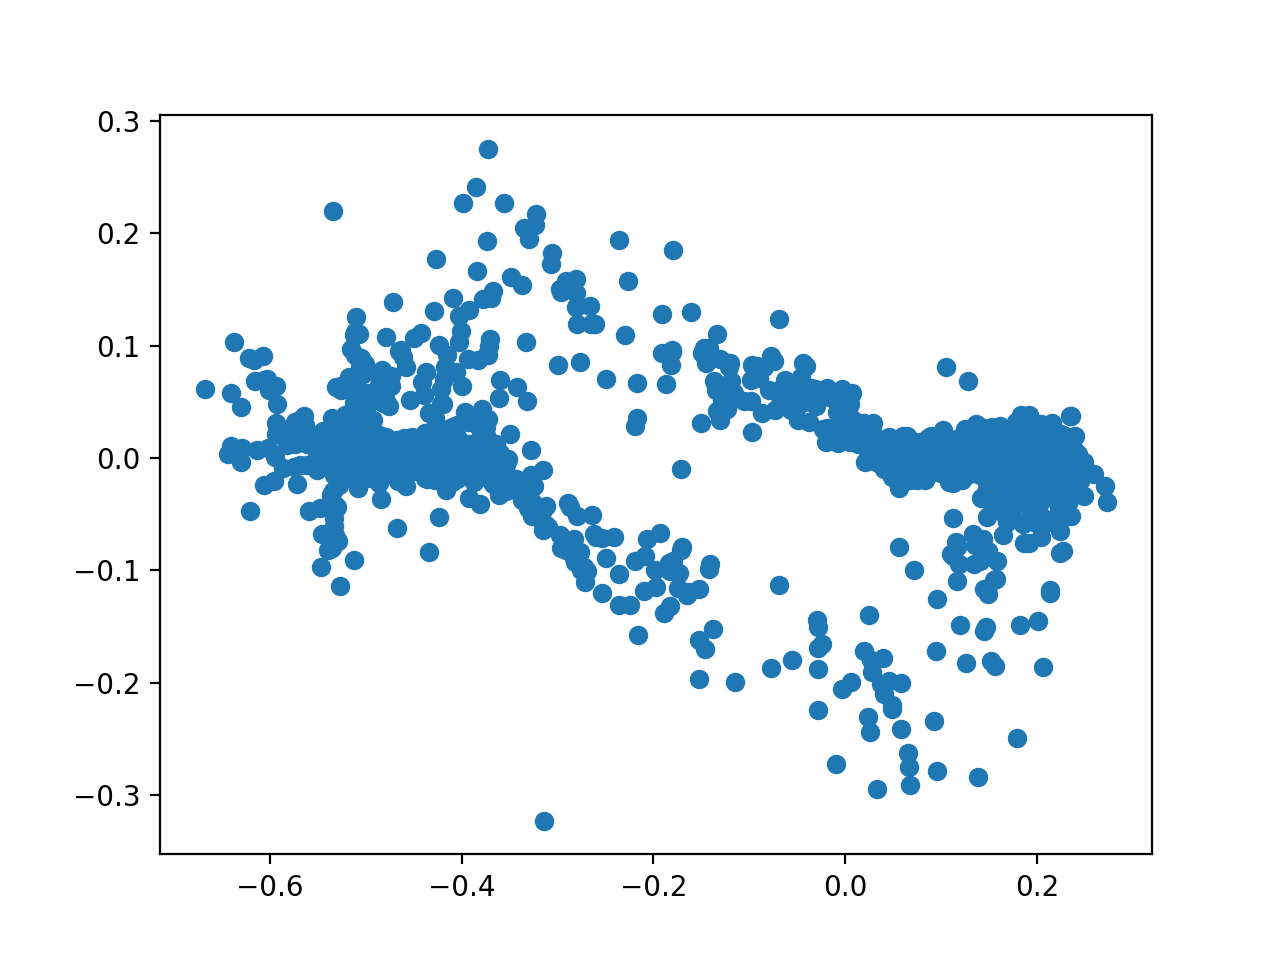

In [5]:
%matplotlib notebook
plt.figure()
plt.scatter(y0_tr[window_size-1:,0], moving_average[:])
#plt.plot(np.linspace(-.5,.5,5), np.linspace(-.5,.5,5))
plt.show()

In [6]:
# algorithm = 'BunDLeNet'
# rat_name = 'achilles'
# 
# file_pattern = f'../../data/generated/saved_Y/{{}}__{algorithm}_rat_{rat_name}'
# y0_tr = np.loadtxt(file_pattern.format('y0_tr'))
# y1_tr = np.loadtxt(file_pattern.format('y1_tr'))
# y0_tst = np.loadtxt(file_pattern.format('y0_tst'))
# y1_tst = np.loadtxt(file_pattern.format('y1_tst'))
# b_train_1 = np.loadtxt(file_pattern.format('b_train_1'))
# b_test_1 = np.loadtxt(file_pattern.format('b_test_1'))
# 
# y0_tr = y0_tr.reshape(y0_tr.shape[0],-1)
# y1_tr = y1_tr.reshape(y1_tr.shape[0],-1)
# y0_tst = y0_tst.reshape(y0_tst.shape[0],-1)
# y1_tst = y1_tst.reshape(y1_tst.shape[0],-1)
# ydiff_tr = y1_tr - y0_tr
# ydiff_tst = y1_tst - y0_tst
# 
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# plot_acf(y0_tr[:,0], lags=50)
# plot_pacf(y0_tr[:,0], lags=50)


In [7]:
# %matplotlib notebook
# plt.figure()
# plt.plot(y0_tr[:,0])
# plt.plot(ydiff_tr[:,0])
# plt.show()

In [8]:
### Scaling input and output data
yinmax = (np.abs(y0_tr)).max() # Parameters for scaling
y0_tr, y0_tst = y0_tr/yinmax, y0_tst/yinmax
ydmax = (np.abs(ydiff_tr)).max() # Parameters for scaling
ydiff_tr, ydiff_tst = ydiff_tr/ydmax, ydiff_tst/ydmax

2024-09-05 16:58:54.960651: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-05 16:58:54.994220: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


<IPython.core.display.Javascript object>


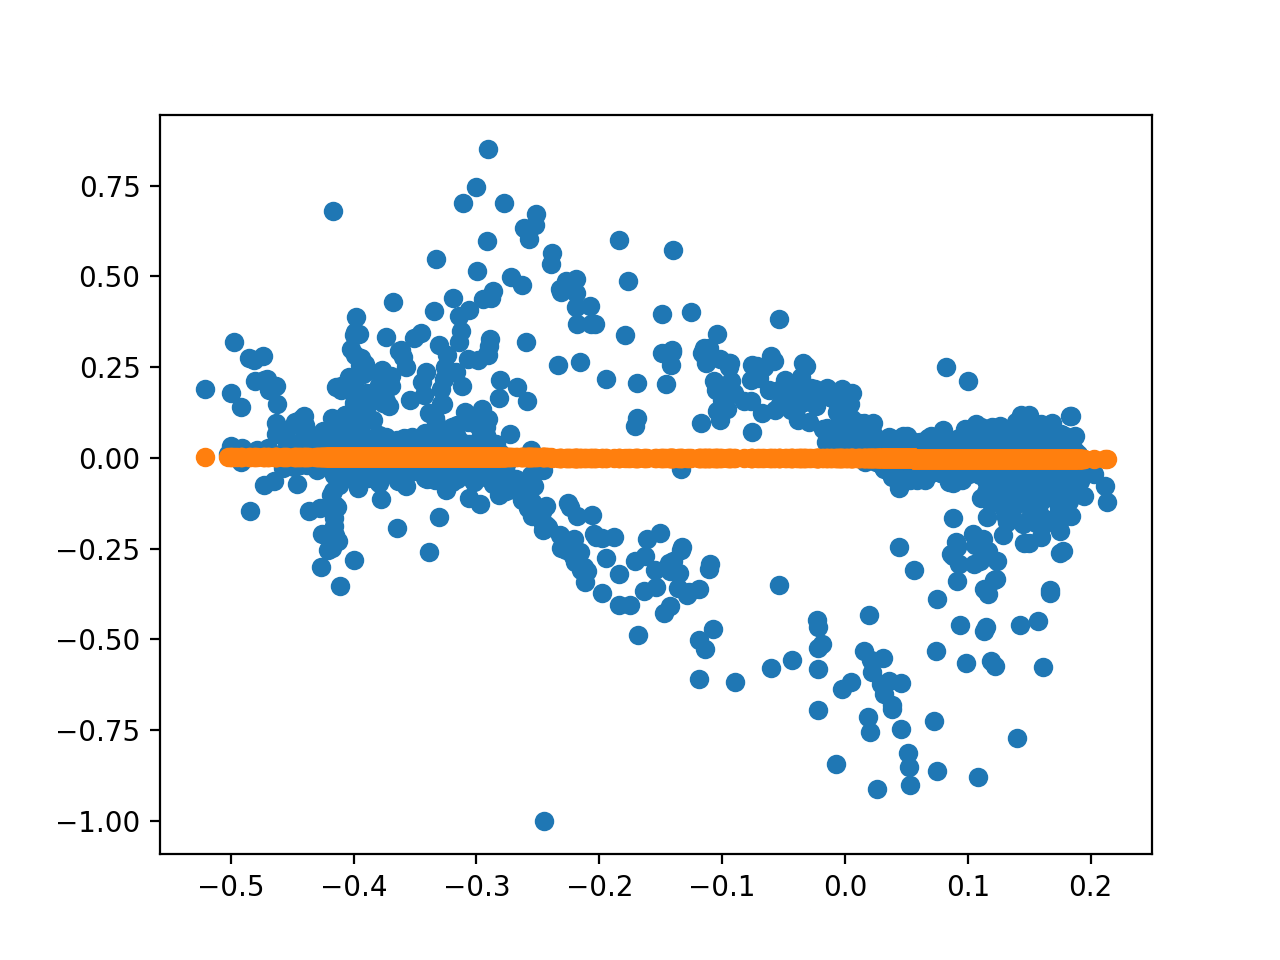

In [9]:

# Defining the model
model_ydiff_f_yt = tf.keras.Sequential([
	tf.keras.layers.Dense(3, activation='linear')])
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model_ydiff_f_yt.compile(optimizer=opt,
			  loss='mse',
			  metrics=['mse'])
plt.figure()
plt.scatter(y0_tr[:,0], ydiff_tr[:,0])
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(y0_tr[:,[0]], ydiff_tr[:,[0]])
y_pred = reg.predict(y0_tr[:,[0]])
plt.scatter(y0_tr[:,0], reg.predict(y0_tr[:,[0]]))

plt.show()

# history = model_ydiff_f_yt.fit(y0_tr,
# 					  ydiff_tr,
# 					  epochs=50,
# 					  batch_size=1000,
# 					  validation_data=(y0_tst, ydiff_tst),
# 					  verbose=0
# 					  )
# plt.figure()
# plt.plot(history.history['mse'], label='Training MSE')
# plt.plot(history.history['val_mse'], label='Validation MSE')
# plt.xlabel('Epochs')
# plt.ylabel('MSE')
# plt.legend()
# plt.show()
# 
# # Predictions
# ydiff_tr_pred = model_ydiff_f_yt(y0_tr).numpy()
# ydiff_tst_pred = model_ydiff_f_yt(y0_tst).numpy()
# 
# # Inverse scaling the data
# ydiff_tr_pred, ydiff_tr, y0_tr = ydiff_tr_pred*ydmax, ydiff_tr*ydmax, y0_tr*yinmax
# ydiff_tst_pred, ydiff_tst, y0_tst = ydiff_tst_pred*ydmax, ydiff_tst*ydmax, y0_tst*yinmax
# 
# y1_tr_pred = y0_tr + ydiff_tr_pred
# y1_tst_pred = y0_tst + ydiff_tst_pred
# 
# # Evaluation
# flat_partial = lambda x: x.reshape(x.shape[0],-1)
# print(y1_tr.shape)
# baseline_tr  = mean_squared_error(flat_partial(y1_tr), flat_partial(y0_tr))
# modelmse_tr = mean_squared_error(flat_partial(y1_tr), flat_partial(y1_tr_pred))
# baseline_tst  = mean_squared_error(flat_partial(y1_tst), flat_partial(y0_tst))
# modelmse_tst = mean_squared_error(flat_partial(y1_tst), flat_partial(y1_tst_pred))
# print(y1_tr.shape)
# 
# print(baseline_tr)
# print(modelmse_tr)
# print(baseline_tst)
# print(modelmse_tst)
# 

In [10]:
y1_tr.shape

(14577, 3)

In [11]:
### Dynamics predictability evaluation
mse_list = []
for i in tqdm(np.arange(10)):
	### Scaling input and output data
	yinmax = (np.abs(y0_tr)).max() # Parameters for scaling
	y0_tr, y0_tst = y0_tr/yinmax, y0_tst/yinmax
	ydmax = (np.abs(ydiff_tr)).max() # Parameters for scaling
	ydiff_tr, ydiff_tst = ydiff_tr/ydmax, ydiff_tst/ydmax

	# Defining the model
	model_ydiff_f_yt = tf.keras.Sequential([
		tf.keras.layers.Dense(3, activation='linear')])
	opt = tf.keras.optimizers.Adam(learning_rate=0.01)
	model_ydiff_f_yt.compile(optimizer=opt,
				  loss='mse',
				  metrics=['mse'])

	history = model_ydiff_f_yt.fit(y0_tr,
						  ydiff_tr,
						  epochs=50,
						  batch_size=1000,
						  validation_data=(y0_tst, ydiff_tst),
						  verbose=0
						  )

	# Predictions
	ydiff_tr_pred = model_ydiff_f_yt(y0_tr).numpy()
	ydiff_tst_pred = model_ydiff_f_yt(y0_tst).numpy()

	# Inverse scaling the data
	ydiff_tr_pred, ydiff_tr, y0_tr = ydiff_tr_pred*ydmax, ydiff_tr*ydmax, y0_tr*yinmax
	ydiff_tst_pred, ydiff_tst, y0_tst = ydiff_tst_pred*ydmax, ydiff_tst*ydmax, y0_tst*yinmax

	y1_tr_pred = y0_tr + ydiff_tr_pred
	y1_tst_pred = y0_tst + ydiff_tst_pred

	# Evaluation
	flat_partial = lambda x: x.reshape(x.shape[0],-1)
	baseline_tr  = mean_squared_error(flat_partial(y1_tr), flat_partial(y0_tr))
	modelmse_tr = mean_squared_error(flat_partial(y1_tr), flat_partial(y1_tr_pred))
	baseline_tst  = mean_squared_error(flat_partial(y1_tst), flat_partial(y0_tst))
	modelmse_tst = mean_squared_error(flat_partial(y1_tst), flat_partial(y1_tst_pred))
	print(baseline_tr)
	print(modelmse_tr)
	print(baseline_tst)
	print(modelmse_tst)


	mse_list.append([baseline_tr, modelmse_tr, baseline_tst, modelmse_tst])


 10%|████▏                                     | 1/10 [00:01<00:17,  1.97s/it]

0.010731240861479427
0.01061325463798552
0.018060272321643898
0.01768157563363725


 20%|████████▍                                 | 2/10 [00:03<00:15,  1.88s/it]

0.010731240861479427
0.011109081320650069
0.018060272321643898
0.018128415427645424


 30%|████████████▌                             | 3/10 [00:05<00:13,  1.87s/it]

0.010731240861479427
0.011077068541855181
0.018060272321643898
0.018173567366192165


 40%|████████████████▊                         | 4/10 [00:07<00:11,  1.85s/it]

0.010731240861479427
0.010988709680009414
0.018060272321643898
0.01805268410047979


 50%|█████████████████████                     | 5/10 [00:09<00:09,  1.86s/it]

0.010731240861479427
0.011209794326861844
0.018060272321643898
0.018254701832730962


 50%|█████████████████████                     | 5/10 [00:10<00:10,  2.14s/it]


KeyboardInterrupt: 

In [ ]:

# Saving the metrics
mse_list = np.array(mse_list)
np.savetxt('../data/generated/evaluation_metrics/mse_list_' + algorithm + '_rat_' +  str(rat_name), mse_list)
